In [1]:
import os
import torch

import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import joblib as jl

from tqdm import tqdm, trange

import sys
sys.path.append("src")  # hacky way to get access to the util.save_perf
from util import save_perf

In [6]:
adata = ad.read_h5ad("data/adata_rosmap_v3_top959.h5ad")
adata_val = ad.read_h5ad("data/seaad959_k30_matched.h5ad")

In [37]:
for st in adata.obs["Supertype"].unique():
    adata_st = adata[adata.obs["Supertype"] == st]
    print(f"\nSupertype: {st}")
    print(adata_st.obs["cell_type_high_resolution"].value_counts())



Supertype: Astrocytes
cell_type_high_resolution
Ast GRM3      82543
Ast DPP10     30865
Ast CHI3L1    23434
Name: count, dtype: int64

Supertype: Excitatory_neurons_set1
cell_type_high_resolution
Excitatory_neurons_set1    257130
Name: count, dtype: int64

Supertype: Excitatory_neurons_set2
cell_type_high_resolution
Exc L3-4 RORB CUX2        149951
Exc L4-5 RORB IL1RAPL2     95076
Exc L4-5 RORB GABRG1       66800
Exc L3-5 RORB PLCH1        33209
Name: count, dtype: int64

Supertype: Excitatory_neurons_set3
cell_type_high_resolution
Exc L6 THEMIS NFIA         56532
Exc RELN CHD7              47319
Exc L6b                    21486
Exc L6 CT                  19990
Exc L5-6 RORB LINC02196    18668
Exc L5/6 IT Car3           15595
Exc L5/6 NP                14750
Exc NRGN                   14526
Exc L5 ET                   2795
Name: count, dtype: int64

Supertype: Immune_cells
cell_type_high_resolution
Mic P2RY12    68666
Mic TPT1       4949
T cells        2296
CAMs           2014
Mic MKI

In [10]:
SAMPLE_COL = "Donor ID"
CELLTYPE_COL = "Subclass"
LABEL = "Label"
LABEL_VAL = "Wang"

In [13]:
train_x = adata.X
train_y = adata.obs[LABEL].values
train_donor_ids = adata.obs[SAMPLE_COL].values  # donor ID each cell belongs to
TRAIN_DONORS = np.unique(train_donor_ids)  # unique donor IDs

# now get the label of each donor in new_donors
# this is the label of the first cell of each donor in new_donors
donor_labels = np.array([
    train_y[train_donor_ids == donor_id][0] for donor_id in TRAIN_DONORS
])

# X = x / x.sum(axis=1).reshape(-1, 1) * 1e4
# X = np.log1p(X)
# X = (X - X.mean(axis=0)) / X.std(axis=0)

In [11]:
val_x = adata_val.X
val_y = adata_val.obs[LABEL_VAL].values
val_donor_ids = adata_val.obs[SAMPLE_COL].values  # donor ID each
VAL_DONORS = np.unique(val_donor_ids)  # unique donor IDs

val_donor_labels = np.array([
    val_y[val_donor_ids == donor_id][0] for donor_id in VAL_DONORS
])

In [14]:
# PCA the entire thing together
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=42)
train_x = pca.fit_transform(train_x)
val_x = pca.transform(val_x)

In [15]:
from umap import UMAP

# randomly sample 100000 cells from the train and validation set
train_sample = np.random.choice(train_x.shape[0], 100000, replace=False)
val_sample = np.random.choice(val_x.shape[0], 100000, replace=False)

combined_x = np.concatenate([train_x[train_sample], val_x[val_sample]], axis=0)

umap = UMAP(n_components=2, verbose=True)
train_umap = umap.fit_transform(combined_x)

c:\Users\timo\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\timo\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Thu Jul  3 14:11:22 2025 Construct fuzzy simplicial set
Thu Jul  3 14:11:22 2025 Finding Nearest Neighbors
Thu Jul  3 14:11:22 2025 Building RP forest with 27 trees
Thu Jul  3 14:11:27 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	Stopping threshold met -- exiting after 5 iterations
Thu Jul  3 14:11:41 2025 Finished Nearest Neighbor Search
Thu Jul  3 14:11:43 2025 Construct embedding


Epochs completed:   2%| ▏          4/200 [00:01]

	completed  0  /  200 epochs


Epochs completed:  12%| █▎         25/200 [00:02]

	completed  20  /  200 epochs


Epochs completed:  23%| ██▎        46/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       64/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▎      85/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     103/200 [00:05]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    124/200 [00:06]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▎   145/200 [00:07]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  163/200 [00:08]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 184/200 [00:09]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:09]


Thu Jul  3 14:14:22 2025 Finished embedding


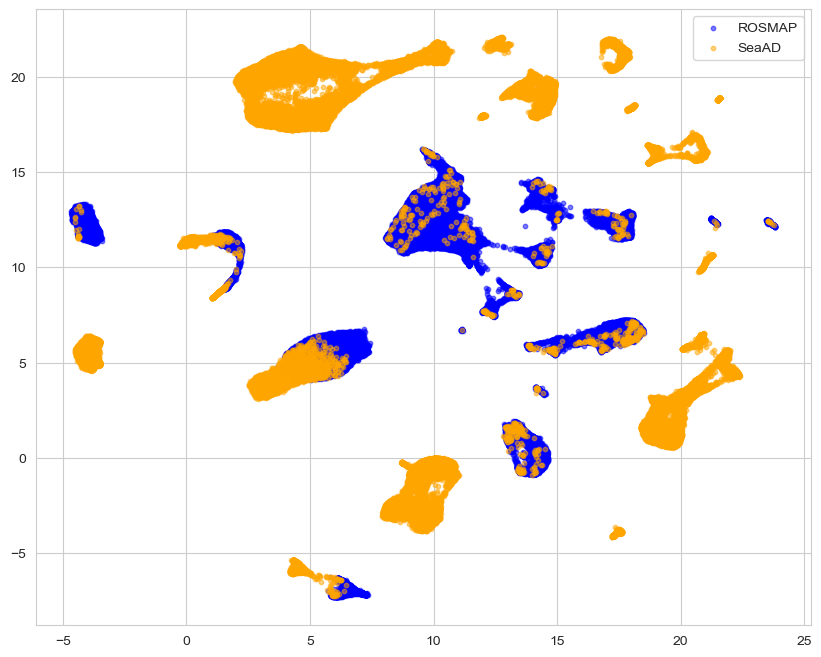

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
plt.scatter(
    x=train_umap[:train_sample.shape[0], 0],
    y=train_umap[:train_sample.shape[0], 1],
    # hue=donor_labels,
    # palette="tab10",
    alpha=0.5,
    s=10,
    c="blue",
    label="ROSMAP"
)
plt.scatter(
    x=train_umap[train_sample.shape[0]:, 0],
    y=train_umap[train_sample.shape[0]:, 1],
    # hue=val_donor_labels,
    alpha=0.5,
    s=10,
    c="orange",
    label="SeaAD"
)

plt.legend()

In [31]:
adata_val.obs.columns.tolist()

['sample_id',
 'Neurotypical reference',
 'Donor ID',
 'Organism',
 'Brain Region',
 'Sex',
 'Gender',
 'Age at Death',
 'Race (choice=White)',
 'Race (choice=Black/ African American)',
 'Race (choice=Asian)',
 'Race (choice=American Indian/ Alaska Native)',
 'Race (choice=Native Hawaiian or Pacific Islander)',
 'Race (choice=Unknown or unreported)',
 'Race (choice=Other)',
 'specify other race',
 'Hispanic/Latino',
 'Highest level of education',
 'Years of education',
 'PMI',
 'Fresh Brain Weight',
 'Brain pH',
 'ADNC',
 'Thal',
 'Braak',
 'CERAD',
 'Overall CAA Score',
 'Highest Lewy Body Disease',
 'Total Microinfarcts (not observed grossly)',
 'Total microinfarcts in screening sections',
 'Atherosclerosis',
 'Arteriolosclerosis',
 'LATE',
 'Cognitive Status',
 'Last CASI Score',
 'Interval from last CASI in months',
 'Last MMSE Score',
 'Interval from last MMSE in months',
 'Last MOCA Score',
 'Interval from last MOCA in months',
 'APOE Genotype',
 'Primary Study Name',
 'Secondary

C:\Users\timo\AppData\Local\Temp\ipykernel_23480\2668422593.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hue=adata.obs["Supertype"][train_sample],


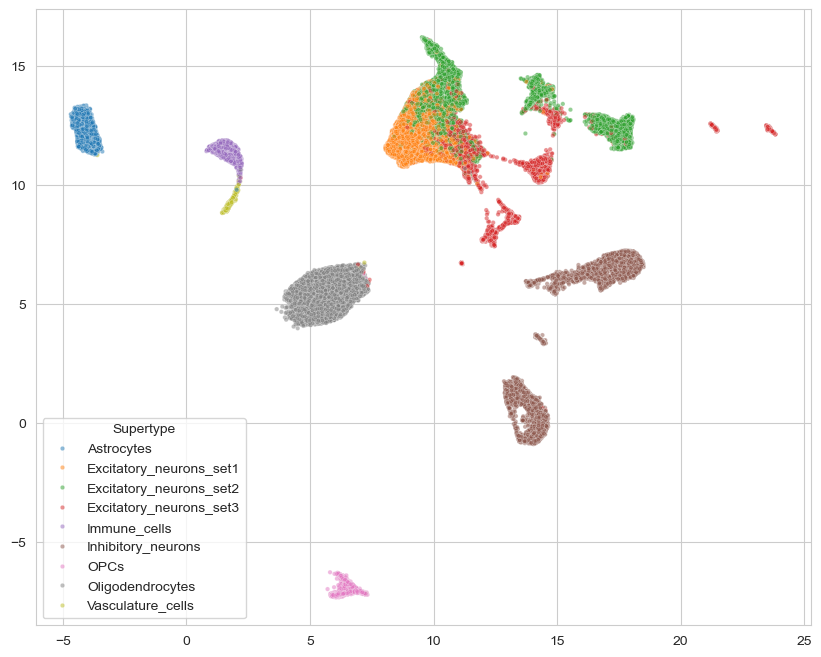

C:\Users\timo\AppData\Local\Temp\ipykernel_23480\2668422593.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hue=adata_val.obs["Class"][val_sample],


<Axes: >

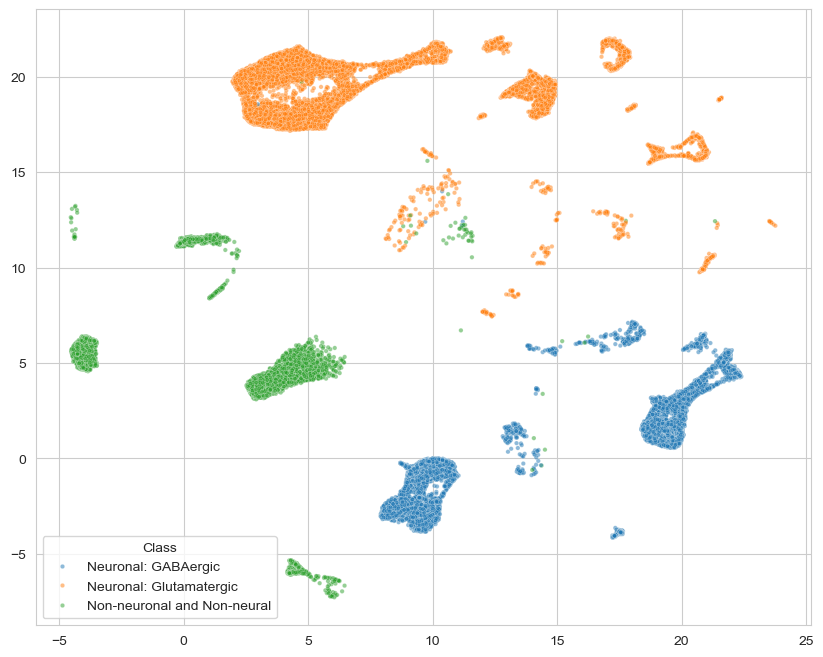

In [35]:
# once more, but now with the cell type labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=train_umap[:train_sample.shape[0], 0],
    y=train_umap[:train_sample.shape[0], 1],
    hue=adata.obs["Supertype"][train_sample],
    palette="tab10",
    alpha=0.5,
    s=10,
    # label="ROSMAP"
)
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=train_umap[train_sample.shape[0]:, 0],
    y=train_umap[train_sample.shape[0]:, 1],
    hue=adata_val.obs["Class"][val_sample],
    alpha=0.5,
    s=10,
)

In [ ]:
SPLIT_SEED = None
# SPLIT_SEED = 42

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Model definition
model = Lasso(alpha=0.03, max_iter=1000)

# Model training
model.fit(train_x, train_y)

# Model evaluation
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

test_auc_cell.append(roc_auc_score(y_test, y_pred_test))

y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)
        
# Metrics per cell
acc_train = (y_pred_train == y_train).mean()
acc_test = (y_pred_test == y_test).mean()

test_acc_cell.append(accuracy_score(y_test, y_pred_test))
test_prec_cell.append(precision_score(y_test, y_pred_test))
test_rec_cell.append(recall_score(y_test, y_pred_test))
test_f1_cell.append(f1_score(y_test, y_pred_test))

# But now we want to aggregate predictions per donor
donor_pred = []
donor_true = []
test_donor_ids = np.array(donor_ids)[np.isin(donor_ids, test_donors)]
for donor in test_donors:
    idx = np.isin(test_donor_ids, donor)
    donor_pred.append(y_pred_test[idx].mean())
    donor_true.append(y_test[idx].mean())
donor_pred = np.array(donor_pred)
donor_true = np.array(donor_true)

# Also for training data 
donor_pred_train = []
donor_true_train = []
train_donor_ids = np.array(donor_ids)[np.isin(donor_ids, train_donors)]
for donor in train_donors:
    idx = np.isin(train_donor_ids, donor)
    donor_pred_train.append(y_pred_train[idx].mean())
    donor_true_train.append(y_train[idx].mean())
donor_pred_train = np.array(donor_pred_train)
donor_true_train = np.array(donor_true_train)

# Pick best threshold based on training data:
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_acc = 0
for threshold in thresholds:
    donor_pred_train_ = (donor_pred_train > threshold).astype(int)
    acc = accuracy_score(donor_true_train, donor_pred_train_)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

# Metrics per donor
test_auc_donor.append(roc_auc_score(donor_true, donor_pred))
donor_pred = (donor_pred > best_threshold).astype(int)

test_acc_donor.append(accuracy_score(donor_true, donor_pred))
test_prec_donor.append(precision_score(donor_true, donor_pred))
test_rec_donor.append(recall_score(donor_true, donor_pred))
test_f1_donor.append(f1_score(donor_true, donor_pred))

print("With best threshold (gridsearch):")
print(f"acc  (cell) = {test_acc_cell[-1]:.4f}, acc  (donor) = {test_acc_donor[-1]:.4f}")
print(f"prec (cell) = {test_prec_cell[-1]:.4f}, prec (donor) = {test_prec_donor[-1]:.4f}")
print(f"rec  (cell) = {test_rec_cell[-1]:.4f}, rec  (donor) = {test_rec_donor[-1]:.4f}")
print(f"f1   (cell) = {test_f1_cell[-1]:.4f}, f1   (donor) = {test_f1_donor[-1]:.4f}")
print(f"auc  (cell) = {test_auc_cell[-1]:.4f}, auc  (donor) = {test_auc_donor[-1]:.4f}")

save_perf(
    exp_name="COMBAT_top2000",
    model_name="CTCC",
    fold=i,
    accuracy=test_acc_donor[-1],
    precision=test_prec_donor[-1],
    recall=test_rec_donor[-1],
    f1=test_f1_donor[-1],
    roc_auc=test_auc_donor[-1],
    train_donors=train_donors,
    test_donors=test_donors,
    train_y=donor_labels[train_index],
    test_y=donor_labels[test_index],
    train_y_pred=donor_pred_train.flatten(),
    test_y_pred=donor_pred.flatten(),
)

print("\nPer cell:")
print(f"Mean test  acc (cell): {np.mean(mean_acc_cell):.4f} +/- {np.std(mean_acc_cell):.4f}")
print(f"Mean test prec (cell): {np.mean(mean_prec_cell):.4f} +/- {np.std(mean_prec_cell):.4f}")
print(f"Mean test  rec (cell): {np.mean(mean_rec_cell):.4f} +/- {np.std(mean_rec_cell):.4f}")
print(f"Mean test   f1 (cell): {np.mean(mean_f1_cell):.4f} +/- {np.std(mean_f1_cell):.4f}")
print(f"Mean test  auc (cell): {np.mean(mean_auc_cell):.4f} +/- {np.std(mean_auc_cell):.4f}")

print("\nPer donor:")
print(f"Mean test  acc: {np.mean(mean_acc_donor):.4f} +/- {np.std(mean_acc_donor):.4f}")
print(f"Mean test prec: {np.mean(mean_prec_donor):.4f} +/- {np.std(mean_prec_donor):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec_donor):.4f} +/- {np.std(mean_rec_donor):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1_donor):.4f} +/- {np.std(mean_f1_donor):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc_donor):.4f} +/- {np.std(mean_auc_donor):.4f}")

Run 1/1
Fold 1/5
With best threshold (gridsearch):
acc  (cell) = 0.7918, acc  (donor) = 0.8571
prec (cell) = 0.8110, prec (donor) = 0.8571
rec  (cell) = 0.9146, rec  (donor) = 0.9474
f1   (cell) = 0.8597, f1   (donor) = 0.9000
auc  (cell) = 0.8418, auc  (donor) = 0.9123
Fold 2/5
With best threshold (gridsearch):
acc  (cell) = 0.7542, acc  (donor) = 0.9286
prec (cell) = 0.7401, prec (donor) = 0.9474
rec  (cell) = 0.9429, rec  (donor) = 0.9474
f1   (cell) = 0.8293, f1   (donor) = 0.9474
auc  (cell) = 0.8485, auc  (donor) = 0.9825
Fold 3/5
With best threshold (gridsearch):
acc  (cell) = 0.7963, acc  (donor) = 0.8929
prec (cell) = 0.8052, prec (donor) = 0.8636
rec  (cell) = 0.9420, rec  (donor) = 1.0000
f1   (cell) = 0.8683, f1   (donor) = 0.9268
auc  (cell) = 0.8452, auc  (donor) = 0.9766
Fold 4/5
With best threshold (gridsearch):
acc  (cell) = 0.8049, acc  (donor) = 0.9286
prec (cell) = 0.8092, prec (donor) = 0.9000
rec  (cell) = 0.9389, rec  (donor) = 1.0000
f1   (cell) = 0.8692, f1   (

## Results

**LASSO (alpha=0.03), 1k genes**
```
100%|██████████| 10/10 [08:49<00:00, 52.93s/it]
Mean test  acc (cell): 0.5503 +/- 0.0079
Mean test prec (cell): 0.5618 +/- 0.0053
Mean test  rec (cell): 0.7893 +/- 0.0142
Mean test   f1 (cell): 0.6521 +/- 0.0066
Mean test  auc (cell): 0.5726 +/- 0.0119

Per donor:
Mean test  acc: 0.5989 +/- 0.0309
Mean test prec: 0.6176 +/- 0.0242
Mean test  rec: 0.7662 +/- 0.0628
Mean test   f1: 0.6677 +/- 0.0445
Mean test  auc: 0.6325 +/- 0.0120
```

**LASSO (alpha=0.03), 2k genes**
```
Mean test  acc (cell): 0.5238 +/- 0.0099
Mean test prec (cell): 0.5410 +/- 0.0062
Mean test  rec (cell): 0.9025 +/- 0.0355
Mean test   f1 (cell): 0.6656 +/- 0.0146
Mean test  auc (cell): 0.5740 +/- 0.0075

Per donor:
Mean test  acc: 0.5568 +/- 0.0111
Mean test prec: 0.5694 +/- 0.0124
Mean test  rec: 0.8934 +/- 0.0451
Mean test   f1: 0.6872 +/- 0.0140
Mean test  auc: 0.5219 +/- 0.0201
```

**LASSO (alpha=0.03), 5k genes**
```
Mean test  acc (cell): 0.5406 +/- 0.0045
Mean test prec (cell): 0.5496 +/- 0.0034
Mean test  rec (cell): 0.8722 +/- 0.0164
Mean test   f1 (cell): 0.6690 +/- 0.0053
Mean test  auc (cell): 0.5680 +/- 0.0098

Per donor:
Mean test  acc: 0.5949 +/- 0.0119
Mean test prec: 0.6003 +/- 0.0111
Mean test  rec: 0.8609 +/- 0.0436
Mean test   f1: 0.7006 +/- 0.0146
Mean test  auc: 0.5764 +/- 0.0200
```

**LASSO (alpha=0.03), 8k genes**
... cancelled due to time limit. Is now running again as job 11062857